In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
train_df.info()
print('------------------------------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 co

### 1. Transported 값 0,1로 변경

In [4]:
#Transpoted 값을 bool 0,1 인트 값으로 변경
train_df['TransNum'] = 0
train_df.loc[(train_df['Transported']), 'TransNum'] = 1
train_df.drop(['PassengerId','Transported','Name'],axis = 1, inplace=True)
test_id = test_df['PassengerId']
test_df.drop(['PassengerId','Name'],axis=1, inplace=True)

### 2. Float 결손값 채우기

In [5]:
for df in [train_df,test_df]:
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    for i in ['RoomService', 'FoodCourt', 'ShoppingMall','Spa','VRDeck']:
        df[i].fillna(0,inplace = True)

<AxesSubplot:>

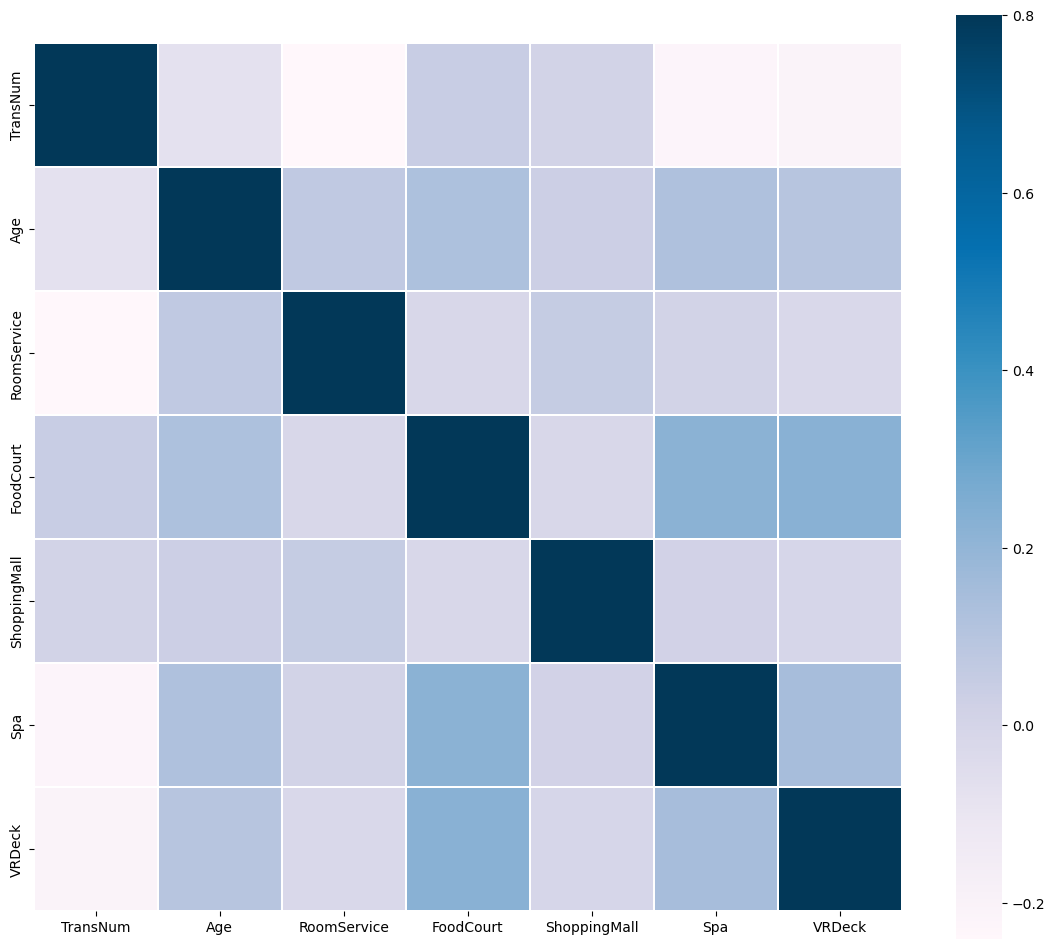

In [6]:
corr_data = train_df[['TransNum','Age', 'RoomService', 'FoodCourt',
                     'ShoppingMall','Spa','VRDeck']]
colormap = plt.cm.PuBu
f, ax = plt.subplots(figsize = (14,12))
sns.heatmap(corr_data.corr(),square = True, linewidths = 0.1,
           cmap = colormap, linecolor = "white", vmax=0.8)

In [7]:
train_df.drop(['RoomService','Spa','VRDeck'],axis=1,inplace=True)
test_df.drop(['RoomService','Spa','VRDeck'],axis=1,inplace=True)

### 3. object 결손값 채우기

#### 3.1 HomePlanet

In [8]:
train_df['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [9]:
# homeplanet은 출발행성으로 결손값 지구로 설정
train_df['HomePlanet'].fillna('Earth', inplace = True)

#### 3.2 CryoSleep

In [10]:
train_df['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [11]:
train_df['CryoSleep'].fillna(False, inplace = True)

In [12]:
from sklearn.preprocessing import LabelEncoder
for df in [train_df, test_df]:
    features = ['HomePlanet', 'CryoSleep']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])

#### 3.3 Cabin

In [13]:
train_df['Cabin'].value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

In [14]:
train_df['deck'] = train_df['Cabin'].str[:1]
train_df['side'] = train_df['Cabin'].str[-1:]

In [15]:
print(train_df['side'].value_counts())
print(train_df['deck'].value_counts())

S    4288
P    4206
Name: side, dtype: int64
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: deck, dtype: int64


<AxesSubplot:>

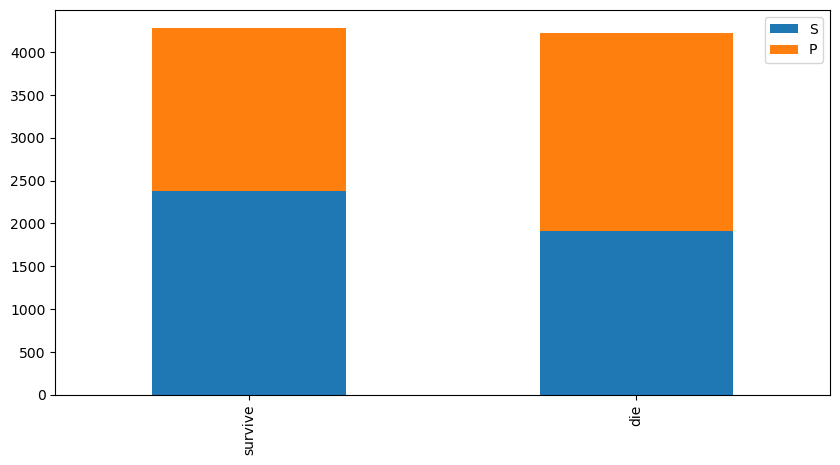

In [16]:
#side는 생존과 상관 없다는 것을 알수 있다.
Pclass1 = train_df[train_df['TransNum']==1]['side'].value_counts()
Pclass2 = train_df[train_df['TransNum']==0]['side'].value_counts()
df = pd.DataFrame([Pclass1,Pclass2])
df.index = ['survive','die']
df.plot(kind='bar',stacked=True,figsize=(10,5))

In [17]:
train_df.drop(['side'],axis=1,inplace=True)

<AxesSubplot:>

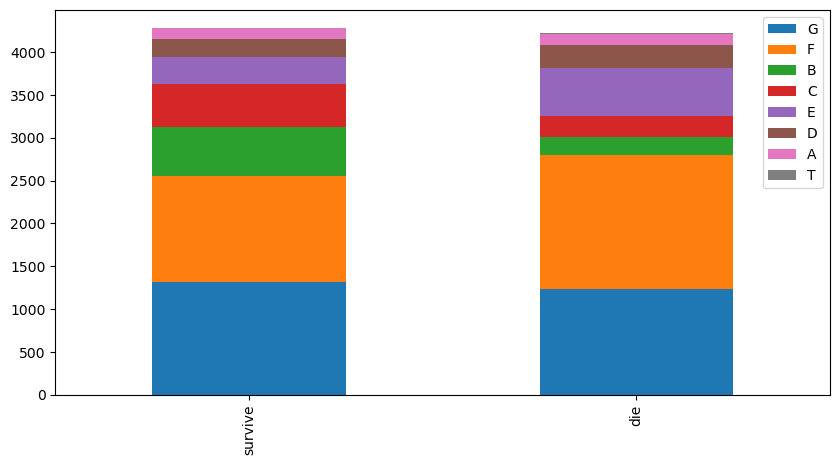

In [18]:
#side도 영향을 주지 않는 것을 볼수있다
Pclass1 = train_df[train_df['TransNum']==1]['deck'].value_counts()
Pclass2 = train_df[train_df['TransNum']==0]['deck'].value_counts()
df = pd.DataFrame([Pclass1,Pclass2])
df.index = ['survive','die']
df.plot(kind='bar',stacked=True,figsize=(10,5))

In [19]:
train_df.drop(['deck','Cabin'],axis=1,inplace=True)
test_df.drop(['Cabin'],axis=1,inplace=True)

#### 3.4 Destination

In [20]:
print(train_df['Destination'].value_counts())
print(test_df['Destination'].value_counts())

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64
TRAPPIST-1e      2956
55 Cancri e       841
PSO J318.5-22     388
Name: Destination, dtype: int64


In [21]:
for df in [train_df,test_df]:
    df['Destination'].fillna('TRAPPIST-1e',inplace=True)
    df['Des_num'] = 1
    df.loc[(df['Destination'] == '55 Cancri e'),'Des_num'] = 2
    df.loc[(df['Destination'] == 'PSO J318.5-22'),'Des_num'] = 3
    df.drop(['Destination'],axis=1,inplace=True)

#### 3.5 VIP

In [22]:
train_df['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [23]:
for df in [train_df,test_df]:
    df['VIP'].fillna(False, inplace = True)
    df['VIPnum'] = 0
    df.loc[(df['VIP']),'VIPnum'] = 1
    df.drop(['VIP'],axis=1,inplace=True)

In [24]:
print('Total null = ', train_df.isnull().sum().sum())
total = train_df.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total], axis=1, keys=['Total'])
missing_data.head(5)

Total null =  0


,Total
HomePlanet,0
CryoSleep,0
Age,0
FoodCourt,0
ShoppingMall,0


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   int64  
 1   CryoSleep     8693 non-null   int64  
 2   Age           8693 non-null   float64
 3   FoodCourt     8693 non-null   float64
 4   ShoppingMall  8693 non-null   float64
 5   TransNum      8693 non-null   int64  
 6   Des_num       8693 non-null   int64  
 7   VIPnum        8693 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 543.4 KB


In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   int64  
 1   CryoSleep     4277 non-null   int64  
 2   Age           4277 non-null   float64
 3   FoodCourt     4277 non-null   float64
 4   ShoppingMall  4277 non-null   float64
 5   Des_num       4277 non-null   int64  
 6   VIPnum        4277 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 234.0 KB


<AxesSubplot:>

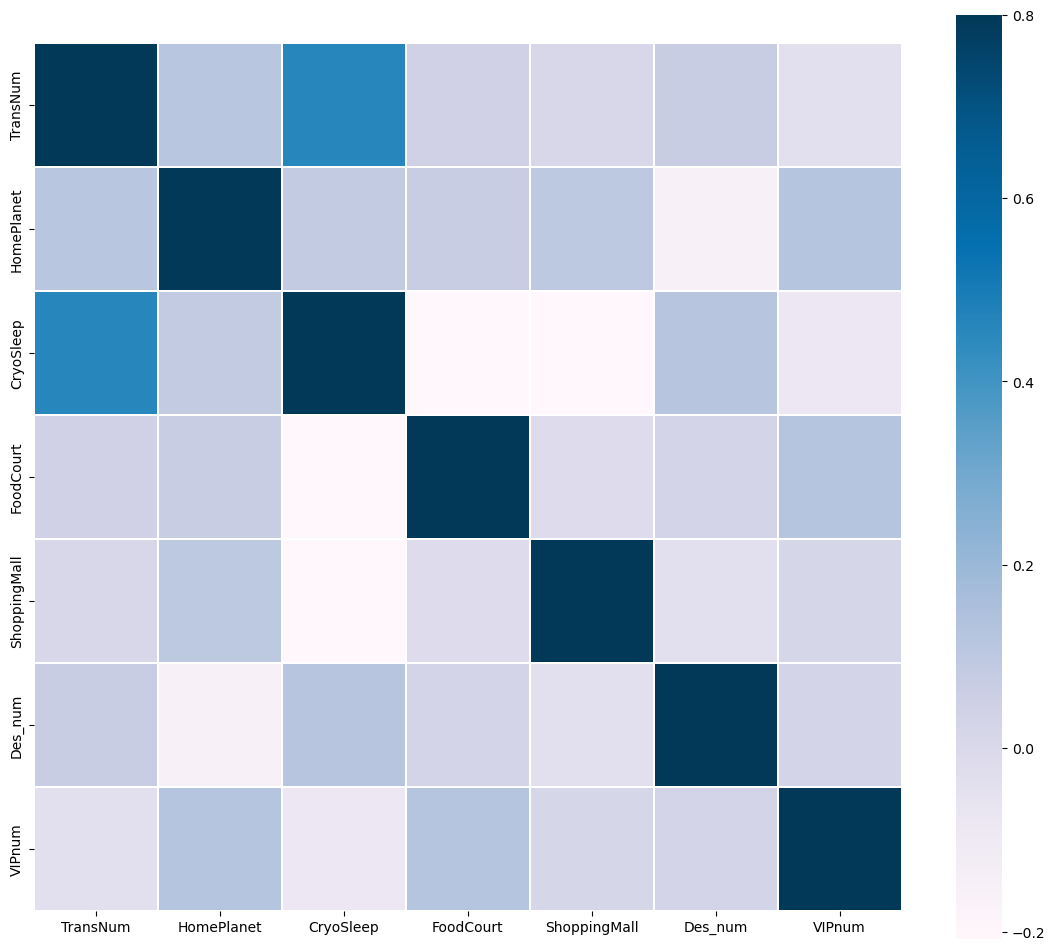

In [27]:
corr_data = train_df[['TransNum', 'HomePlanet', 'CryoSleep', 'FoodCourt',
                     'ShoppingMall', 'Des_num', 'VIPnum']]
colormap = plt.cm.PuBu
f, ax = plt.subplots(figsize = (14,12))
sns.heatmap(corr_data.corr(),square = True, linewidths = 0.1,
           cmap = colormap, linecolor = "white", vmax=0.8)

### 모델링

In [28]:
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [29]:
y_train_df = train_df['TransNum']
X_train_df = train_df.drop('TransNum',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train_df,
        y_train_df, test_size = 0.2, random_state=11)

In [30]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [31]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [32]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.7291546866014951
SCORE:
0.7291546866014951
SCORE:
0.6894767107533065
SCORE:
0.6894767107533065
SCORE:
0.6894767107533065
SCORE:
0.7274295572167913
SCORE:
0.660149511213341
SCORE:
0.7280046003450259
SCORE:
0.660149511213341
SCORE:
0.7285796434732605
SCORE:
0.660149511213341
SCORE:
0.6630247268545141
SCORE:
0.660149511213341
SCORE:
0.6894767107533065
SCORE:
0.7280046003450259
SCORE:
0.6618746405980449
SCORE:
0.7280046003450259
SCORE:
0.6630247268545141
SCORE:
0.6630247268545141
SCORE:
0.7291546866014951
SCORE:
0.6630247268545141
SCORE:
0.7285796434732605
SCORE:
0.6630247268545141
SCORE:
0.7222541690626797
SCORE:
0.7280046003450259
SCORE:
0.660149511213341
SCORE:
0.7245543415756182
SCORE:
0.7291546866014951
SCORE:
0.7274295572167913
SCORE:
0.726279470960322
SCORE:
0.684301322599195
SCORE:
0.726279470960322
SCORE:
0.660149511213341
SCORE:
0.7285796434732605
SCORE:
0.6630247268545141
SCORE:
0.7274295572167913
SCORE:
0.6630247268545141
SCORE:
0.7285796434732605
SCORE:
0.689476710753

In [33]:
print(best_hyperparams)

{'colsample_bytree': 0.6043031595249713, 'gamma': 5.074463335561938, 'max_depth': 11.0, 'min_child_weight': 6.0, 'reg_alpha': 81.0, 'reg_lambda': 0.29546362918115726}


In [34]:
model = xgb.XGBClassifier(colsample_bytree= 0.7209900478002447, gamma= 3.9981954741983894,
                          max_depth= 14, min_child_weight= 10.0, reg_alpha= 76.0,
                          reg_lambda= 0.36894584904759925)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7209900478002447, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=3.9981954741983894, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=14, max_leaves=0,
              min_child_weight=10.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=76.0, reg_lambda=0.36894584904759925, ...)

In [35]:
model.score(X_train,y_train)

0.7364106988783434

### Make answer

In [36]:
X_test = test_df.values
pred_ans = model.predict(X_test)
ans_df = pd.DataFrame()
ans_df['PassengerId'] = test_id
ans_df['TransNum'] = pred_ans
ans_df['Transported'] = True
ans_df.loc[(ans_df['TransNum'] == 0),'Transported'] = False
ans_df.drop(['TransNum'],axis=1,inplace=True)
print(ans_df)

     PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01        False
4        0023_01        False
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01        False
4276     9277_01         True

[4277 rows x 2 columns]


In [37]:
ans_df.to_csv('/kaggle/working/spaceship_answer.csv',index=False)